# NBD Lab Project

## Install all the needed pip dependencies

In [77]:
%%capture
!pip install -r requirements.txt

## Importing the needed libraries

In [1]:
import polars as pl
import pandas as pd
from pathlib import Path

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

## Setting the needed paths

In [2]:
current_path = Path('.')
data_path = current_path/'data'
pcap_path = data_path/'pcap.parquet'

## 1) Extract general info from your trace using capinfos

In [3]:
!python src/capinfos.py

Getting capture infos about data/data_00000_20190410070000.pcap

Number of packets  in the capture:
-----------------------------------------------------------------
File name:           data/data_00000_20190410070000.pcap
Packet size limit:   inferred: 34 bytes - 96 bytes (range)
Number of packets:   5,000 k


The average data reate in bits/sec:
-----------------------------------------------------------------
File name:           data/data_00000_20190410070000.pcap
Packet size limit:   inferred: 34 bytes - 96 bytes (range)
Data bit rate:       2,729 Mbps


The average packet size:
-----------------------------------------------------------------
File name:           data/data_00000_20190410070000.pcap
Packet size limit:   inferred: 34 bytes - 96 bytes (range)
Average packet size: 1198.22 bytes


General all infos:
-----------------------------------------------------------------
File name:           data/data_00000_20190410070000.pcap
File type:           Wireshark/... - pcapng
File 

In [4]:
display(pl.read_csv(data_path/'capinfos.csv'))

File name,File type,File encapsulation,File time precision,Packet size limit,Packet size limit min (inferred),Packet size limit max (inferred),Number of packets,File size (bytes),Data size (bytes),Capture duration (seconds),Start time,End time,Data byte rate (bytes/sec),Data bit rate (bits/sec),Average packet size (bytes),Average packet rate (packets/sec),SHA256,RIPEMD160,SHA1,Strict time order,Capture hardware,Capture oper-sys,Capture application,Capture comment
str,str,str,str,str,i64,i64,i64,i64,i64,f64,str,str,f64,f64,f64,f64,str,str,str,bool,str,str,str,str
"""data/data_0000…","""pcapng""","""ether""","""microseconds""","""(not set)""",34,96,5000000,490189160,5991123026,17.55763,"""2019-04-10 07:…","""2019-04-10 07:…",3.4123e8,2.7298e9,1198.22,284776.48,"""17c90cad2fbbde…","""fc1047598207df…","""968263edd2013c…",false,"""""","""""","""Editcap (Wires…",""""""


## 2) Time Evaluation between Sequential and Parallel reading

For solving this question we have written a specific script `extract_packets.py`, which can be found in the `src/` folder.

Because we have used the [joblib.Parallel()](https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html) framework our script is able to perform both sequential and parallel reading.

#### Sequential Reading

To perform a sequential reading, in a terminal from the root folder run:

```bash
python src/extract_packets.py -j 1
```

The `-j` argument set to 1 will tell `Parallel` to use only 1 worker, resulting in a sequential run.

#### Parallel Reading

To use all the available workes just run in a terminal from the root folder.

```bash
python src/extract_packets.py
```

If you want to use a specific number of workers just set `-j` accordingly (e.g. `-j 4` to use 4 workers).

### Results on the entire pcap (5M of packets)

|Type of Reading| Time (seconds)|Time (minutes)|
|-------------------|------|-------------|
|Sequential Reading|12410.356|206.84|
|Parallel Reading|11692.876|194.88|

> These results were obtained using a *12th Gen Intel i5-1235U (12) @ 4.400GHz* CPU and using all the available workers (12) for Parallel reading.

## Read the parquet file and get the 1M sample

In [19]:
n = 1_000_000
seed = 42
df = pl.read_parquet(pcap_path).sample(n=n, seed=seed)

In [6]:
display(df)

dsfield_dscp,hdr_len,dsfield,dsfield_ecn,len,proto,flags_df,flags_mf,flags_rb,frag_offset,ttl,src,dst,srcport,dstport,sniff_timestamp
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64,i64,f64
0,20,0,0,52,6,0,0,0,0,54,"""180.213.208.20…","""203.122.136.47…",53480,80,1.5549e9
0,20,0,0,64,6,1,0,0,0,59,"""202.7.172.153""","""162.242.40.3""",50472,443,1.5549e9
0,20,0,0,141,17,0,0,0,0,58,"""150.57.190.76""","""155.70.48.196""",50821,27023,1.5549e9
0,20,0,0,234,6,0,0,0,0,124,"""216.116.245.17…","""131.137.49.212…",443,55950,1.5549e9
0,20,0,0,95,17,1,0,0,0,57,"""23.53.35.140""","""131.137.126.25…",53,48350,1.5549e9
0,20,0,0,1420,6,1,0,0,0,56,"""150.57.136.251…","""221.244.225.17…",80,64918,1.5549e9
0,20,0,0,1420,6,1,0,0,0,56,"""150.57.136.251…","""221.244.225.17…",80,64918,1.5549e9
0,20,0,0,1500,6,1,0,0,0,56,"""150.57.136.251…","""39.18.205.141""",80,64480,1.5549e9
0,20,0,0,1454,6,1,0,0,0,61,"""203.122.131.14…","""122.9.35.9""",80,63963,1.5549e9


## 3) Extract the IP which generates the highest amount of sender traffic, evaluate the bit rate (0.1 sec) for the 6 IP addresses mostly used as endpoint

In [65]:
def bit_rate():
    ...

In [120]:

def bitRate(data, step_sec = 1):
    start = data.iloc[0]["sniff_timestamp"]
    finish = data.iloc[-1]["sniff_timestamp"]
    print("Start: ",start)
    print("Finish: ",finish)
    
    
    data["sniff_timestamp"] -= data.iloc[0]["sniff_timestamp"]
    start = data.iloc[0]["sniff_timestamp"]
    finish = data.iloc[-1]["sniff_timestamp"]
    
    print("Start: ",start)
    print("Finish: ",finish)
    
    step = finish/ step_sec
    finish = start + step_sec
    value = []
    print(step)
    for i in range(int(step)):
    
        #From Byte to bit - selection of the time interval between the start and the end of a single time slot
        #print(data[(data["sniff_timestamp"]>=start) & (data["sniff_timestamp"]<finish)])
        val = np.sum(data[(data["sniff_timestamp"]>=start) & (data["sniff_timestamp"]<finish)]["len"]*8)
        if not np.isnan(val):
            value.append(val/step_sec)
        start = finish 
        finish = start + step_sec

    print(len(value))
        
    return value#, data



In [121]:
bitRate(df.sample(n=10, seed=seed).sort(by="sniff_timestamp").to_pandas())

Start:  1554872403.385683
Finish:  1554872416.75434
Start:  0.0
Finish:  13.368656873703003
13.368656873703003
13


[736.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 416.0,
 11504.0,
 12416.0,
 320.0,
 12000.0,
 0.0]

In [7]:
ip_highest_traffic = (df
                      .lazy()
                      .groupby(by='src')
                      .count()
                      .sort(by='count', descending=True)).collect().get_column("src")[0]

most_used_endpoints = (df
                       .lazy()
                       .filter(pl.col("src")==ip_highest_traffic)
                       .groupby(by="dst")
                       .count()
                       .sort(by="count", descending=True)
                       .head(6)
                       .select(pl.col("dst"))).collect()

with pl.Config(fmt_str_lengths=20):
    display(most_used_endpoints)

dst
str
"""66.132.46.70"""
"""115.181.56.11"""
"""153.153.206.192"""
"""221.244.225.179"""
"""60.160.157.207"""
"""39.18.205.141"""


## 7) 10 Protocol mostly used

First of all we retrieve the list of IP protocols with their respective codes, available at the [Internet Assigned Numbers Authority](https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml).

In [95]:
proto_to_protocols_df = pd.read_html('https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml', match='Decimal').pop()[['Decimal', 'Protocol', 'Keyword']]
proto_to_protocols_df

,Decimal,Protocol,Keyword
0,0,IPv6 Hop-by-Hop Option,HOPOPT
1,1,Internet Control Message,ICMP
2,2,Internet Group Management,IGMP
3,3,Gateway-to-Gateway,GGP
4,4,IPv4 encapsulation,IPv4
...,...,...,...
145,145,Network Service Header,NSH
146,146-252,Unassigned,NaN
147,253,Use for experimentation and testing,NaN
148,254,Use for experimentation and testing,NaN


The `Decimal` column contains the protocol number code, which is number between 0 and 255.

We can notice a major problem tho: some protocols doesn't have an unique code, but multiple... for this reason we're going to clean the dataframe with the following funtion.

In [101]:
def clear_df(dataframe: pd.DataFrame) -> pd.DataFrame:
    """A function that search for all the protocols that have multiple decimal code (e.g. 146-252) and then returns
    a cleaned version of the dataframe in which those protocols appear one time for each decimal code.

    Args:
        - dataframe (pd.DataFrame): The original pandas.DataFrame.

    Returns:
        - df (pd.DataFrame): The cleaned version of 'dataframe'.
    """
    # Get a copy of dataframe
    df = dataframe.copy()

    # For each protocols that contains '-' in the Decimal column (has multiple Decimal codes)
    for prt in dataframe[dataframe.Decimal.str.contains('-')]['Protocol']:
        # Get first and last codes
        first, last = tuple(map(int, dataframe[dataframe.Protocol == prt].Decimal.item().split('-')))
        # Get the Keyword
        keyw = dataframe[dataframe.Protocol == prt].Keyword.item()
        # Create a temporary pandas.DataFrame with the Protcl repeated for each Decimal code 
        temp = pd.DataFrame({'Decimal': list(range(first, last+1)),
                             'Protocol': prt,
                             'Keyword': keyw})
        # Remove the Protocol from the original copy
        df = df[df.Protocol != prt]
        # Concat the temporary dataframe to the copy
        df = pd.concat([df, temp], ignore_index=True)
    # Set the type of the Decimal column to numeric
    df['Decimal'] = df['Decimal'].apply(pd.to_numeric)
    # Return the sorted cleaned dataframe
    return df.sort_values(by="Decimal", ignore_index=True).set_index('Decimal')

In [97]:
proto_to_protocols_df = clear_df(proto_to_protocols_df)
display(proto_to_protocols_df)

,Protocol,Keyword
Decimal,,
0,IPv6 Hop-by-Hop Option,HOPOPT
1,Internet Control Message,ICMP
2,Internet Group Management,IGMP
3,Gateway-to-Gateway,GGP
4,IPv4 encapsulation,IPv4
...,...,...
251,Unassigned,NaN
252,Unassigned,NaN
253,Use for experimentation and testing,NaN


10 Protocol mostly used


,proto,count,Protocol,Keyword
0,6,951956,Transmission Control,TCP
1,17,35101,User Datagram,UDP
2,1,12594,Internet Control Message,ICMP
3,50,245,Encap Security Payload,ESP
4,97,71,Ethernet-within-IP Encapsulation,ETHERIP
5,4,24,IPv4 encapsulation,IPv4
6,89,5,OSPFIGP,OSPFIGP
7,47,4,Generic Routing Encapsulation,GRE


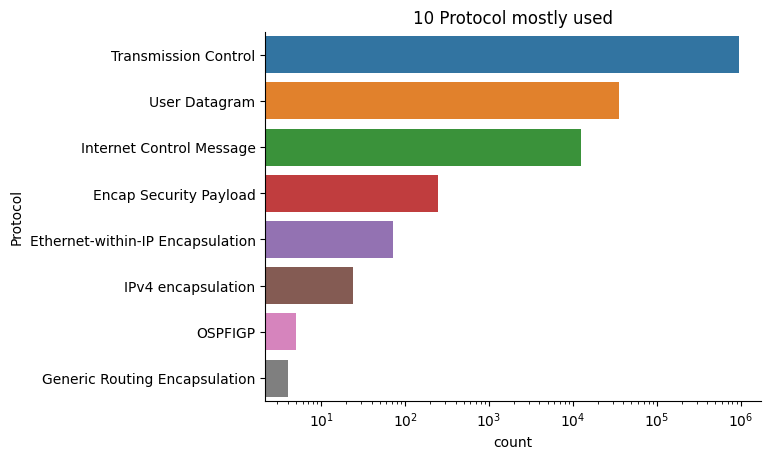

In [100]:
most_used_protocol_10 = (df
                        .lazy()
                        .groupby(by="proto")
                        .count()
                        .sort(by="count", descending=True)
                        .head(10)).collect()

most_used_protocol_10 = pd.merge(most_used_protocol_10.to_pandas(), proto_to_protocols_df, how='left', left_on="proto", right_on="Decimal")

print("10 Protocol mostly used")
display(most_used_protocol_10)

plot = sns.barplot(most_used_protocol_10,
                   x="count",
                   y="Protocol",
                   orient='h',
                   order=most_used_protocol_10["Protocol"].to_numpy())
plot.set(title="10 Protocol mostly used",
         ylabel="Protocol",
         xscale="log")
sns.despine()
plt.show()